### Campaign Finance in US Elections: Exploratory Data Analysis
#### Top things Learned about US Campaign Finance with Python
#### Objectives:
- Explore campaign finance data with Python and Visualization
- Explore associations and predictors with less emphasis on prediction
- Focus on Federal Congressional elections
- Follow the funds: where do campaign funds come from, and where do they go?
- Jupyter Notebook on GitHub: Paul H3000 
- [Data Source: Federal Election Commission](https://www.fec.gov/data/)
![title](data/IMG_3009.PNG)
![title](data/image1.jpeg)

In [86]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

### Import House & Senate campaign finance data
- Data contains one record for each campaign with summary financial information.
- drop rows with invalid state codes: only the 50 US states have congressmen
- deduct double counting activity from candidates' total receipts

In [87]:
#column names: campaign finance data for House and Senate campaigns
col_list = ['CAND_ID',
'CAND_NAME',
'CAND_ICI',
'PTY_CD',
'CAND_PTY_AFFILIATION',
'TTL_RECEIPTS',
'TRANS_FROM_AUTH',
'TTL_DISB',
'TRANS_TO_AUTH',
'COH_BOP',
'COH_COP',
'CAND_CONTRIB',
'CAND_LOANS',
'OTHER_LOANS',
'CAND_LOAN_REPAY',
'OTHER_LOAN_REPAY',
'DEBTS_OWED_BY',
'TTL_INDIV_CONTRIB',
'CAND_OFFICE_ST',
'CAND_OFFICE_DISTRICT',
'SPEC_ELECTION',
'PRIM_ELECTION',
'RUN_ELECTION',
'GEN_ELECTION',
'GEN_ELECTION_PERCENT',
'OTHER_POL_CMTE_CONTRIB',
'POL_PTY_CONTRIB',
'CVG_END_DT',
'INDIV_REFUNDS',
'CMTE_REFUNDS']

In [88]:
#import campaign finance data for House and Senate campaigns, for all election cycles
import glob
the_files = list(glob.glob('../ga_projects/data/house-senate-campaigns/web*.txt'))

df_list = []
for a_file in the_files:
    data = pd.read_csv(a_file, sep='|', header=None, names = col_list)
    #add column indicating the election cycle (ex: 2016 = 2014-16 cycle)
    yr = a_file[len(a_file)-6: len(a_file)-4]
    if yr[0:1]=='9':
        yr = 1900 + int(yr)
    else:
        yr = 2000 + int(yr)
    data['election_cycle'] = yr
    df_list.append(data)

df1 = pd.concat(df_list, axis=0)
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22280 entries, 0 to 1913
Data columns (total 31 columns):
CAND_ID                   22280 non-null object
CAND_NAME                 22280 non-null object
CAND_ICI                  21243 non-null object
PTY_CD                    22280 non-null int64
CAND_PTY_AFFILIATION      22256 non-null object
TTL_RECEIPTS              22280 non-null float64
TRANS_FROM_AUTH           22280 non-null float64
TTL_DISB                  22280 non-null float64
TRANS_TO_AUTH             22280 non-null float64
COH_BOP                   22280 non-null float64
COH_COP                   22280 non-null float64
CAND_CONTRIB              22280 non-null float64
CAND_LOANS                22280 non-null float64
OTHER_LOANS               22280 non-null float64
CAND_LOAN_REPAY           22280 non-null float64
OTHER_LOAN_REPAY          22280 non-null float64
DEBTS_OWED_BY             22280 non-null float64
TTL_INDIV_CONTRIB         22280 non-null float64
CAND_OFFICE_ST  

In [89]:
df1.head()

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PERCENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,election_cycle
0,H8AK00074,"DUNCAN, JIM (JAMES W DUNCAN)",C,1,DEM,572111.0,0.0,570894.0,0.0,0.0,...,W,NaN,L,35.0,67660.0,15200.0,12/31/1998,1050.0,300.0,1998
1,H8AK00082,"PECHEK, STU",C,1,DEM,40061.0,0.0,39828.0,0.0,0.0,...,L,NaN,NaN,0.0,0.0,45.0,12/31/1998,1567.0,0.0,1998
2,H6AK00045,"YOUNG, DONALD",I,2,REP,1371426.0,0.0,1385073.0,13000.0,27213.0,...,W,NaN,W,63.0,662948.0,10953.0,12/31/1998,8990.0,3000.0,1998
3,H4AL01032,"CALLAHAN, HERBERT L",I,2,REP,354389.0,0.0,263347.0,0.0,88123.0,...,W,NaN,W,100.0,177685.0,0.0,12/31/1998,0.0,0.0,1998
4,H8AL02072,"FONDREN, GERALD JOSEPH",C,1,DEM,22164.0,0.0,22134.0,0.0,0.0,...,W,NaN,L,31.0,2500.0,3000.0,12/31/1998,100.0,0.0,1998


In [90]:
#drop data with invalid state code
#use inverted mask
bad_states = ['00','VI','PR','AS','GU','DC','MP']
df1 = df1[~df1.CAND_OFFICE_ST.isin(bad_states)]

In [91]:
#check there are 50 states in data
len(df1.CAND_OFFICE_ST.unique())

50

In [92]:
#deduct double counting activity from candidate's total receipts
#if candidate has more than 1 campaign committe they can transfer funds between them
df1.TTL_RECEIPTS = df1.TTL_RECEIPTS - df1.TRANS_FROM_AUTH - df1.TRANS_TO_AUTH

### Merge federal election results from external data files into main dataframe
- necessary because election results data is missing in 2014 & 2016 cycles
- data for 2014-16 cycles downloaded from FEC site
- clean data, add new features

In [93]:
#data files containing 2014 and 2016 congressional election results
df_elec2014 = pd.read_csv('data/house-senate-campaigns/federalelections2014.csv')
df_elec2016 = pd.read_csv('data/house-senate-campaigns/federalelections2016.csv')
df_elec2014_16 = pd.concat([df_elec2014, df_elec2016], axis=0)

In [94]:
df_elec2014_16.head()

,FEC_ID,PRIMARY_PCT,GENERAL_PCT,ELEC_CYCLE
0,H0AL02087,1.000000,0.673425,2014
1,H0AL05163,0.803156,0.744241,2014
2,H0AL07086,0.839086,0.983723,2014
3,H0AR01083,1.000000,0.632536,2014
4,H0AR03055,1.000000,0.794145,2014


In [95]:
#change column names to align with main df
df_elec2014_16.columns = ['CAND_ID', 'PRIMARY_PCT', 'GENERAL_PCT', 'election_cycle']

In [96]:
#merge into main dataframe on two columns: candidate ID and election cycle
df1 = pd.merge(df1, df_elec2014_16, how='left', on=['CAND_ID', 'election_cycle'])

In [97]:
#consolidate the 2 general-election-pct columns
df1['GEN_ELECTION_PERCENT'] = np.where((df1['election_cycle']==2014) | (df1['election_cycle']==2016),
                                       df1['GENERAL_PCT']*100, df1['GEN_ELECTION_PERCENT'])

df1.drop(['GENERAL_PCT'], axis=1, inplace=True)

In [98]:
#fill in missing 'W' and 'L' values for the general election

#group by the separate elections in each district and year
df1_grp = df1.groupby(['election_cycle','CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT'])

#replace each value in a group with the max value of the group:
df1_max_gen = df1_grp['GEN_ELECTION_PERCENT'].transform(max)

#find row indices containing the max value of general election % (by group)
bools = (df1['GEN_ELECTION_PERCENT'] == df1_max_gen)

#add a new win_or_lose column related to general election
df1['GEN_W_or_L'] = np.where(bools, 'W', 'L')

#reconcile the two win/loss columns for general election
df1['GEN_W_or_L'] = np.where((df1.GEN_ELECTION=='W') & (df1['GEN_W_or_L']=='L'), 'W', df1['GEN_W_or_L'])
df1['GEN_W_or_L'] = np.where((df1.GEN_ELECTION=='L') & (df1['GEN_W_or_L']=='W'), 'L', df1['GEN_W_or_L'])

#fix values for the 2018 cycle, the general election has not occurred yet
df1['GEN_W_or_L'] = np.where(df1.election_cycle==2018, np.nan, df1['GEN_W_or_L'])  

In [99]:
#identify candidates who reached the general election
df1['reached_general'] = np.where(df1['GEN_ELECTION_PERCENT'].notnull(), 1, 0)

In [100]:
#Party codes: 1=democrat, 2=republican, 3=other
df1.PTY_CD.value_counts()

2    10039
1     9069
3     1637
Name: PTY_CD, dtype: int64

In [101]:
#Replace party codes with more descriptive labels
dict_pty = {1:'DEM', 2:'REP', 3:'OTHER'}
df1.PTY_CD = df1.PTY_CD.map(dict_pty)

In [102]:
#add feature identifying house and senate campaigns
df1['house_or_senate'] = df1.CAND_ID.str[:1]

In [103]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20745 entries, 0 to 20744
Data columns (total 35 columns):
CAND_ID                   20745 non-null object
CAND_NAME                 20745 non-null object
CAND_ICI                  19993 non-null object
PTY_CD                    20745 non-null object
CAND_PTY_AFFILIATION      20727 non-null object
TTL_RECEIPTS              20745 non-null float64
TRANS_FROM_AUTH           20745 non-null float64
TTL_DISB                  20745 non-null float64
TRANS_TO_AUTH             20745 non-null float64
COH_BOP                   20745 non-null float64
COH_COP                   20745 non-null float64
CAND_CONTRIB              20745 non-null float64
CAND_LOANS                20745 non-null float64
OTHER_LOANS               20745 non-null float64
CAND_LOAN_REPAY           20745 non-null float64
OTHER_LOAN_REPAY          20745 non-null float64
DEBTS_OWED_BY             20745 non-null float64
TTL_INDIV_CONTRIB         20745 non-null float64
CAND_OFFICE_ST

In [104]:
#create some additional dataframes
df_funds_nonzero = df1[df1.TTL_RECEIPTS>0]

#discard 2018 cycle
#needed for certain plots because the general election has not occurred yet
df_funds = df1[(df1.TTL_RECEIPTS>0) & (df1.election_cycle<2018)]
df_funds['TTL_RECEIPTS_log'] = np.log(df_funds.TTL_RECEIPTS)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### 1. Individual donors contribute largest share of congressional campaign funds

(1996, 2018)

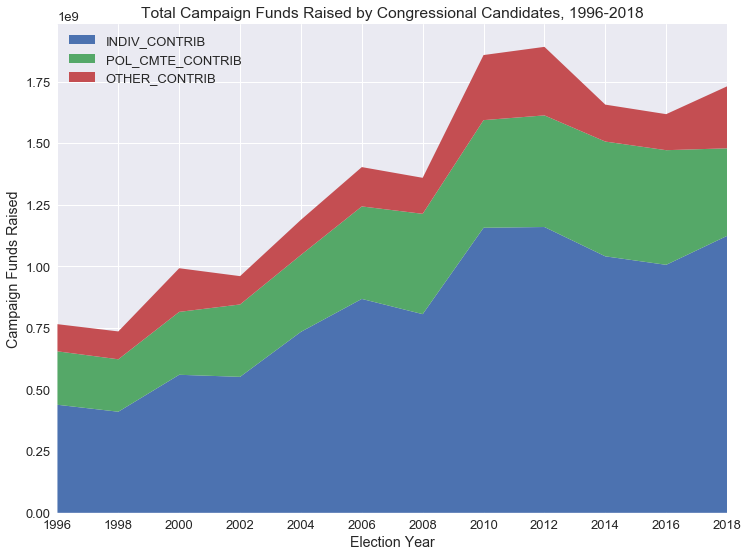

In [105]:
#Growth in total congressional campaign contributions across election cycles

grouped = df1.groupby('election_cycle')[['TTL_RECEIPTS', 'TTL_INDIV_CONTRIB',
                                         'OTHER_POL_CMTE_CONTRIB','POL_PTY_CONTRIB', 
                                         'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS']].sum().reset_index()
#grouped.sort_values(by='TTL_RECEIPTS',ascending=False, inplace=True)
# --> other political committees: contains PAC contributions 
# --> POL_PTY_CONTRIB: party committee contributions

#consolidate to fewer columns for stack chart
grouped2 = pd.DataFrame()
grouped2['INDIV_CONTRIB'] = grouped.TTL_INDIV_CONTRIB
grouped2['POL_CMTE_CONTRIB'] = grouped.OTHER_POL_CMTE_CONTRIB + grouped.POL_PTY_CONTRIB
grouped2['OTHER_CONTRIB'] = grouped.CAND_CONTRIB + grouped.CAND_LOANS + grouped.OTHER_LOANS

plt.figure(figsize = (12,9))
x_vals = grouped['election_cycle']
y_vals = grouped2.loc[:, 'INDIV_CONTRIB' : 'OTHER_CONTRIB'].T #transpose

ax = plt.stackplot(x_vals, y_vals, labels=grouped2.columns) 
plt.legend(loc='upper left')
plt.title('Total Campaign Funds Raised by Congressional Candidates, 1996-2018')
plt.xlabel('Election Year')
plt.ylabel('Campaign Funds Raised')
plt.xticks(np.arange(x_vals.iloc[0], x_vals.iloc[-1]+1, 2))
plt.xlim(x_vals.iloc[0], x_vals.iloc[-1])
#ax = sns.barplot(x='house_or_senate', y='TTL_RECEIPTS',data=grouped)
#sns.set(font_scale=1.3)

#TODO: format y axis in $ billions
#fmt = '${x:,.0f}'

### 2. Explore predictors of Congressional election spending

In [106]:
df1.describe()

,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,COH_COP,CAND_CONTRIB,CAND_LOANS,OTHER_LOANS,CAND_LOAN_REPAY,...,TTL_INDIV_CONTRIB,CAND_OFFICE_DISTRICT,GEN_ELECTION_PERCENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,INDIV_REFUNDS,CMTE_REFUNDS,election_cycle,PRIMARY_PCT,reached_general
count,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,2.074500e+04,...,2.074500e+04,20739.000000,11058.000000,2.074500e+04,20745.000000,2.074500e+04,2.074500e+04,20745.000000,1163.000000,20745.000000
mean,7.804498e+05,2.460597e+04,7.748426e+05,8.995035e+03,1.135265e+05,1.520206e+05,2.242557e+04,7.448125e+04,2.099511e+03,1.700814e+04,...,4.752735e+05,8.638748,40.791328,2.018024e+05,3108.276080,9.156384e+03,1.968466e+03,2007.925283,0.783782,0.533044
std,1.951320e+06,2.669564e+05,2.039733e+06,1.210173e+05,4.568604e+05,5.726799e+05,3.960739e+05,7.658167e+05,6.520269e+04,1.872247e+05,...,1.411646e+06,10.395189,27.331795,3.937775e+05,12850.005377,5.694808e+04,1.828494e+04,7.004489,0.249773,0.498919
min,-4.883476e+06,-6.000000e+03,-1.000000e+04,-1.782512e+04,-4.305800e+04,-7.119828e+04,-5.000000e+03,-7.500000e+05,-1.396813e+04,-1.640000e+04,...,-7.281600e+04,0.000000,0.000000,0.000000e+00,-565.000000,-1.760000e+04,-2.600000e+04,1996.000000,0.005317,0.000000
25%,2.207300e+04,0.000000e+00,2.196433e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,9.363000e+03,2.000000,21.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2002.000000,0.594477,0.000000
50%,1.767940e+05,0.000000e+00,1.804198e+05,0.000000e+00,0.000000e+00,1.865000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,9.469912e+04,5.000000,42.995985,4.750000e+03,0.000000,0.000000e+00,0.000000e+00,2008.000000,0.876295,1.000000
75%,8.711240e+05,0.000000e+00,8.119947e+05,0.000000e+00,1.936519e+04,5.689970e+04,1.499000e+03,1.060000e+04,0.000000e+00,0.000000e+00,...,4.536570e+05,11.000000,62.000000,2.764332e+05,1000.000000,2.800000e+03,0.000000e+00,2014.000000,1.000000,1.000000
max,6.325352e+07,1.638692e+07,6.320951e+07,1.159832e+07,1.805543e+07,1.715663e+07,2.353808e+07,6.019897e+07,8.580000e+06,1.647500e+07,...,4.142904e+07,53.000000,100.000000,4.368642e+06,769655.000000,3.447215e+06,1.025588e+06,2018.000000,1.000000,1.000000


[Text(0,0.5,'Mean Funds Raised'),
 Text(0.5,0,'Candidate Party'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle, 1996-2018')]

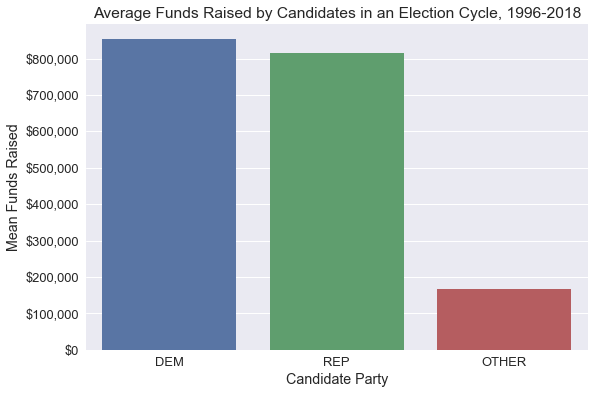

In [107]:
#avg funds raised by candidates according to party affiliation:
#independent candidates raise less funds on average than the major parties

plt.figure(figsize = (9,6))
grouped = df1.groupby('PTY_CD')['TTL_RECEIPTS'].mean().reset_index()
grouped.sort_values(by='TTL_RECEIPTS',ascending=False, inplace=True)
ax = sns.barplot(x='PTY_CD', y='TTL_RECEIPTS',data=grouped)
fmt = '${x:,.0f}'
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 

sns.set(font_scale=1.3)
ax.set(xlabel='Candidate Party', ylabel='Mean Funds Raised',
       title='Average Funds Raised by Candidates in an Election Cycle, 1996-2018')

[Text(0,0.5,'Mean Funds Raised'),
 Text(0.5,0,'House or Senate Campaign'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle, 1996-2018')]

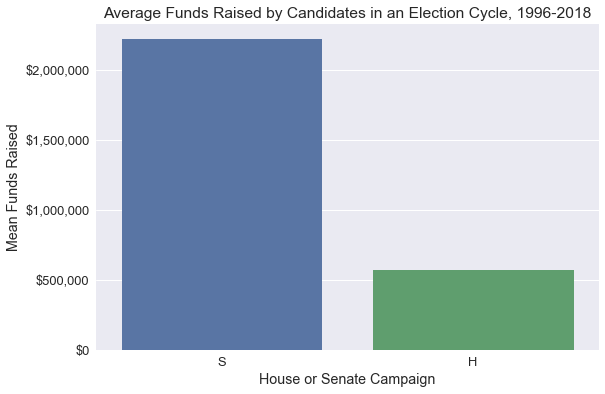

In [108]:
#avg funds raised by House & Senate campaigns
#Senate campaigns raise more funds

plt.figure(figsize = (9,6))
grouped = df1.groupby('house_or_senate')['TTL_RECEIPTS'].mean().reset_index()
grouped.sort_values(by='TTL_RECEIPTS',ascending=False, inplace=True)
ax = sns.barplot(x='house_or_senate', y='TTL_RECEIPTS',data=grouped)
fmt = '${x:,.0f}'
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 

sns.set(font_scale=1.3)
ax.set(xlabel='House or Senate Campaign', ylabel='Mean Funds Raised',
       title='Average Funds Raised by Candidates in an Election Cycle, 1996-2018')

[Text(0,0.5,'Mean Funds Raised'),
 Text(0.5,0,'Incumbent or Challenger Campaign'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle, 1996-2018')]

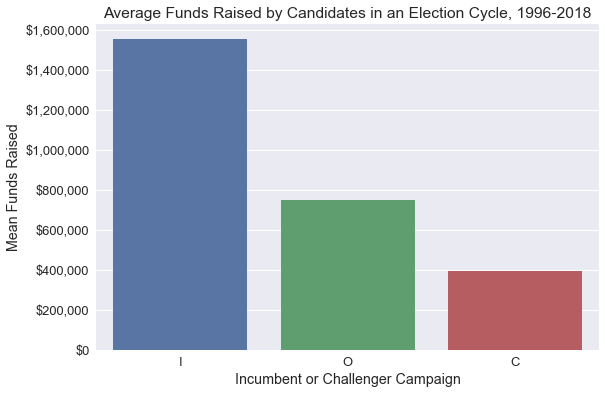

In [109]:
#avg funds raised by Incumbent and Challenger campaigns
#Incumbent campaigns raise more funds
#I=incumbent; C=challenger; O=open seat (where no incumbent sought reelection)

plt.figure(figsize = (9,6))
grouped = df1.groupby('CAND_ICI')['TTL_RECEIPTS'].mean().reset_index()
grouped.sort_values(by='TTL_RECEIPTS',ascending=False, inplace=True)
ax = sns.barplot(x='CAND_ICI', y='TTL_RECEIPTS',data=grouped)
fmt = '${x:,.0f}'
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 

sns.set(font_scale=1.3)
ax.set(xlabel='Incumbent or Challenger Campaign', ylabel='Mean Funds Raised',
       title='Average Funds Raised by Candidates in an Election Cycle, 1996-2018')

### 3. Predictive model of congressional fundraising in election cycles
- use random forest regressor to find important features
- also run linear regression
- correlation does not equal causation

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,0,'Funds Raised (log)'),
 Text(0.5,1,'Distribution of Funds Raised by Candidates in an Election Cycle')]

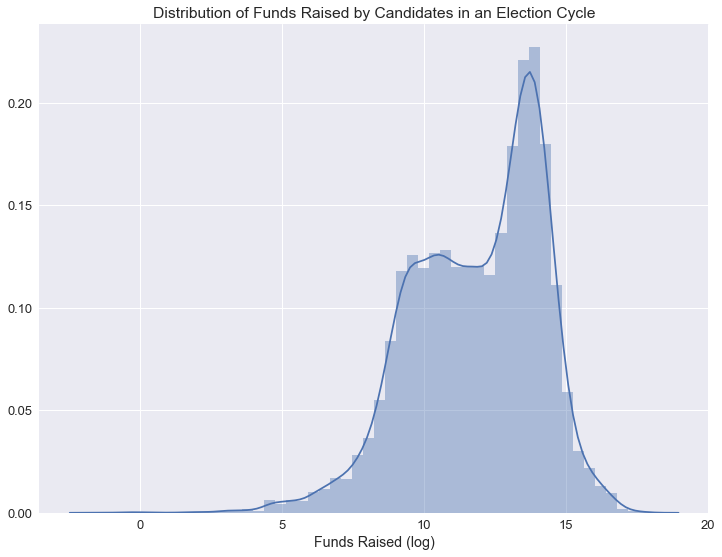

In [110]:
#Density plots of funds raised by candidates in an election cycle
#plot log values to remove skew

#there are 2 classes of fundraisers according to the bimodal shape of the distribution (2 peaks)
# --> middle class and gilded class
plt.figure(figsize = (12,9))
ax = sns.distplot(np.log(df_funds_nonzero.TTL_RECEIPTS))
ax.set(xlabel='Funds Raised (log)', 
       title='Distribution of Funds Raised by Candidates in an Election Cycle')

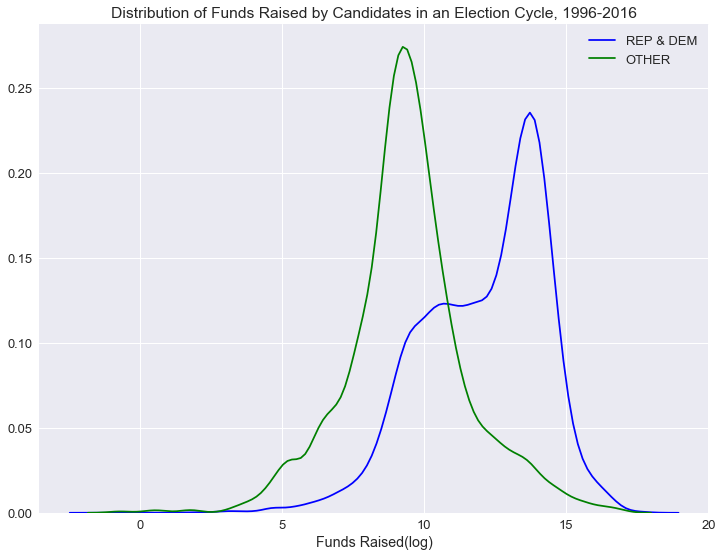

In [111]:
#fund raising distribution, split into 2 groups:
# --> REP & DEM parties
#--> independent (OTHER) parties

#still observe 2 peaks in the REP/DEM distribution: hence amongst Rs & Ds there is gilded and middle class
#observe that independent (OTHER) parties raise less funds
plt.figure(figsize = (12,9))
df_rd = df_funds[df_funds.PTY_CD != 'OTHER']
df_oth = df_funds[df_funds.PTY_CD == 'OTHER']

sns.distplot(df_rd['TTL_RECEIPTS_log'], color='blue', label="REP & DEM", hist=False)
sns.distplot(df_oth['TTL_RECEIPTS_log'], color='green', label="OTHER",hist=False)
plt.title('Distribution of Funds Raised by Candidates in an Election Cycle, 1996-2016')
plt.xlabel('Funds Raised(log)')
plt.legend() 

In [112]:
rf = RandomForestRegressor(max_depth=4) 
X = df_funds[['PTY_CD', 'reached_general', 'house_or_senate', 'CAND_ICI', 'election_cycle']] #'GEN_W_or_L'
X = pd.get_dummies(X, drop_first=True)
y = df_funds['TTL_RECEIPTS_log']

In [113]:
rf.fit(X, y) 
y_pred = rf.predict(X)
rf_score = rf.score(X, y) 
rmse_rf = np.sqrt(mean_squared_error(y, y_pred))
print('Random Forest Regressor Score:', rf_score, '\nRMSE:', rmse_rf)

Random Forest Regressor Score: 0.4132443115965245 
RMSE: 1.7468973887106645


In [114]:
#regression model yields similar score to RF
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X, y) 
y_pred = lr.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
score = lr.score(X, y)
print('Ordinary Regression Score:', score, '\nRMSE:', rmse)

Ordinary Regression Score: 0.4226388649258219 
RMSE: 1.73285615938627


Random Forest Score = 41.3%
Ordinary Regression Score = 42.3%


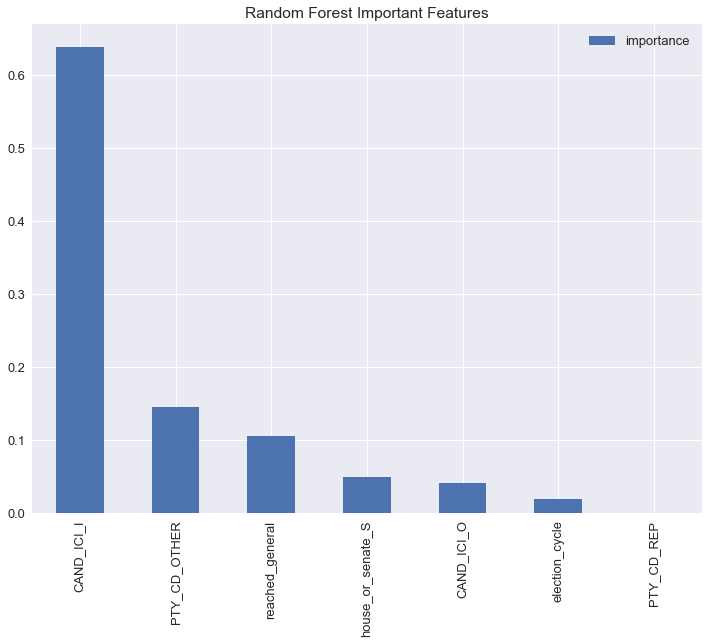

In [115]:
#important features identified by RF
#looks like most important predictors of fundraising are:
# -- incumbent candidates
# -- independent (OTHER) party affiliation
# -- reaching the general election (after the primaries)
# -- House vs Senate candidates
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize = (12,9))
plt.title("Random Forest Important Features")
print('Random Forest Score = {:.1f}%'.format(rf_score*100))
print('Ordinary Regression Score = {:.1f}%'.format(score*100))

### 4. Explore predictors of Congressional election results

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,0,'Congressional General Election Pct of Votes Received'),
 Text(0.5,1,'Distribution of Percent of Vote Received by Candidates in an Election Cycle')]

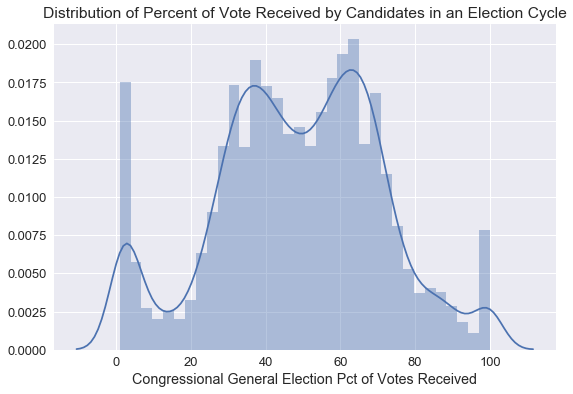

In [116]:
#distribution of general election results
#observe multimodal distribution with 3 peaks:
# -- candidates receiving very little votes, or maybe bad data
# -- candidates who receive substantial votes but lose
# -- candidates who win
df_gen_elect = df_funds[df_funds.GEN_ELECTION_PERCENT.notnull() & (df_funds.GEN_ELECTION_PERCENT>=1.0)]

plt.figure(figsize = (9,6))
ax = sns.distplot(df_gen_elect.GEN_ELECTION_PERCENT)
ax.set(xlabel='Congressional General Election Pct of Votes Received', 
       title='Distribution of Percent of Vote Received by Candidates in an Election Cycle')

[Text(0,0.5,'Mean Funds Raised'),
 Text(0.5,0,'Election Result'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle, 1996-2016')]

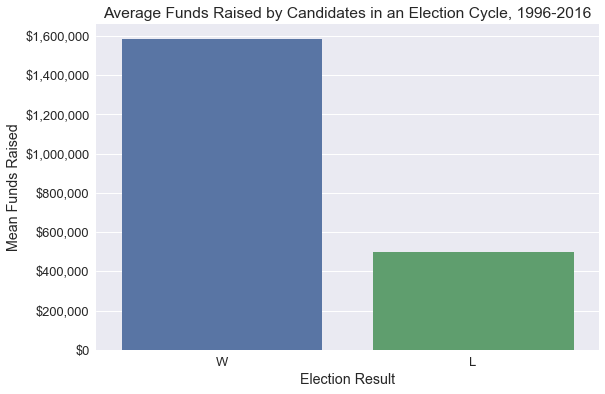

In [117]:
#avg funds raised split by general election outcome (win or lose)
#candidates who win the general election raise more funds

plt.figure(figsize = (9,6))
grouped = df1.groupby('GEN_W_or_L')['TTL_RECEIPTS'].mean().reset_index()
grouped.sort_values(by='TTL_RECEIPTS',ascending=False, inplace=True)
ax = sns.barplot(x='GEN_W_or_L', y='TTL_RECEIPTS',data=grouped)
fmt = '${x:,.0f}'
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 

sns.set(font_scale=1.3)
ax.set(xlabel='Election Result', ylabel='Mean Funds Raised',
       title='Average Funds Raised by Candidates in an Election Cycle, 1996-2016')

[Text(0,0.5,'Mean Funds Raised'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle, 1996-2018')]

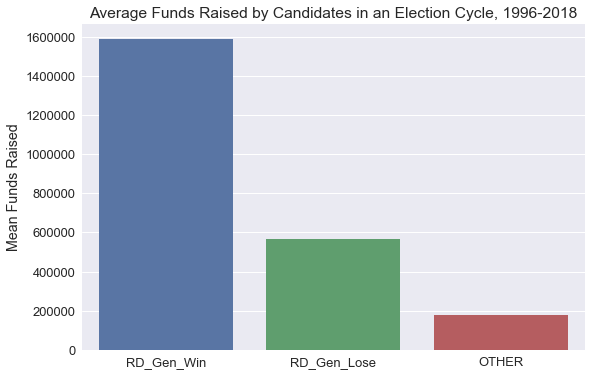

In [118]:
#mean funds raised by the 3 groups in an election cycle
y_vals = [ df_rd_y['TTL_RECEIPTS'].mean(), df_rd_n['TTL_RECEIPTS'].mean(), df_oth['TTL_RECEIPTS'].mean()]
x_vals = ['RD_Gen_Win', 'RD_Gen_Lose', 'OTHER']

plt.figure(figsize = (9,6))
ax = sns.barplot(x= x_vals, y = y_vals)
sns.set(font_scale=1.3)
ax.set(ylabel='Mean Funds Raised',
       title='Average Funds Raised by Candidates in an Election Cycle, 1996-2018')

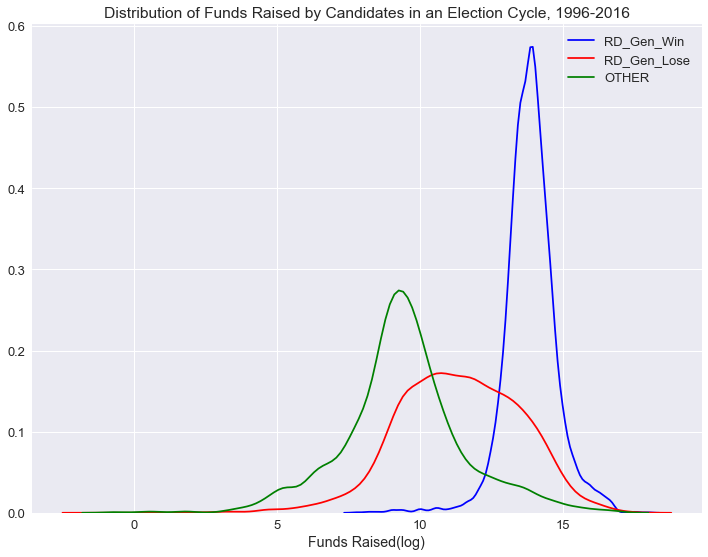

In [119]:
#fund raising distribution

#split REP's and DEM's into 2 classes:
#--> candidates who win general election
#--> candidates who do not win general election

#keep independent (OTHER) candidates in separate group

#observe each of the 3 groups looks symmetrically distributed (log scale)
#this explains the peaks in the combined distribution
plt.figure(figsize = (12,9))
df_rd_y = df_funds[(df_funds.PTY_CD != 'OTHER') & (df_funds['GEN_W_or_L']=='W')]
df_rd_n = df_funds[(df_funds.PTY_CD != 'OTHER') & (df_funds['GEN_W_or_L']=='L')]
df_oth = df_funds[df_funds.PTY_CD == 'OTHER']

sns.distplot(df_rd_y['TTL_RECEIPTS_log'], color='blue', label="RD_Gen_Win", hist=False)
sns.distplot(df_rd_n['TTL_RECEIPTS_log'], color='red', label="RD_Gen_Lose",hist=False)
sns.distplot(df_oth['TTL_RECEIPTS_log'], color='green', label="OTHER",hist=False)
plt.title('Distribution of Funds Raised by Candidates in an Election Cycle, 1996-2016')
plt.xlabel('Funds Raised(log)')
plt.legend()

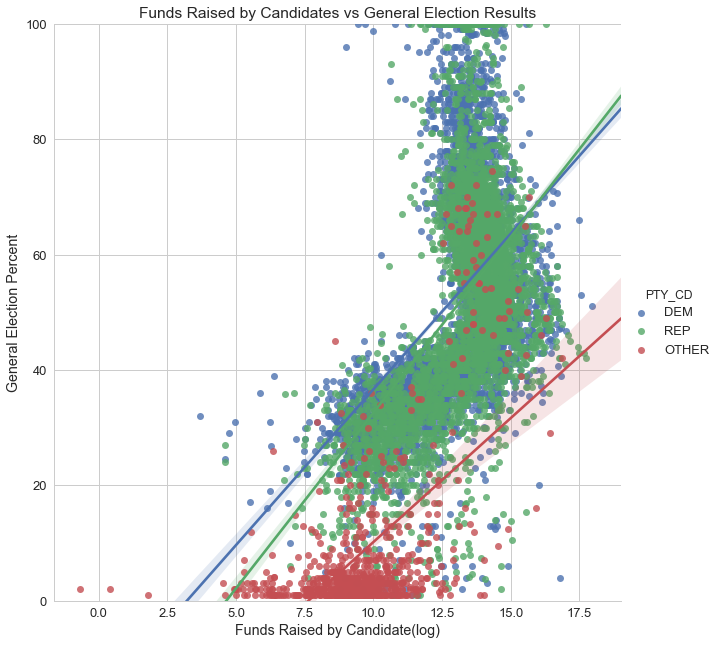

In [151]:
#Is there positive correlation between general election results and funds raised
# -- observe there is positive relationship, but not linear
# -- observe that candidates who are exceeding 50% of vote do not spend more

ax = sns.lmplot(x='TTL_RECEIPTS_log', y='GEN_ELECTION_PERCENT', data=df_gen_elect, 
           hue='PTY_CD', size=9)
plt.ylim(0, 100)
#plt.xlim(100000, 10000000)

ax.set(xlabel='Funds Raised by Candidate(log)', ylabel='General Election Percent',
       title='Funds Raised by Candidates vs General Election Results')

#### Most congressional elections are won by biggest fundraiser
- mosaic plot

In [121]:
#identify biggest fundraiser in each election district / election cycle:
df_funds_grp = df_funds.groupby(['election_cycle','CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT'])

#replace each value in a group with the max value of the group:
df_max_funds = df_funds_grp['TTL_RECEIPTS'].transform(max)

#find row indices containing the max value of general election % (by group)
bools_max = (df_funds['TTL_RECEIPTS'] == df_max_funds)

#add a new max_funds column identifying biggest fundraiser 
df_funds['max_funds'] = np.where(bools_max, 'CashBoss', 'CashBaby')

#df_funds[['TTL_RECEIPTS', 'max_funds']].head(20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Percent of congressional elections won by biggest fundraiser 1996-2016 = 83.4%
4260
849
640
12017


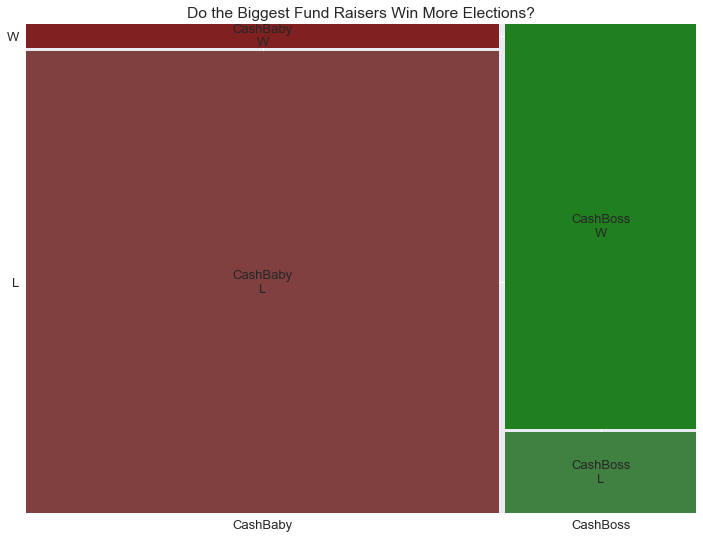

In [122]:
# 83% of congressional elections are won by biggest fundraiser
from statsmodels.graphics.mosaicplot import mosaic
nr_big_wins = len(df_funds[(df_funds['max_funds']=='CashBoss') & (df_funds.GEN_W_or_L=='W')]) #4260

nr_elections = len(df_funds[(df_funds['max_funds']=='CashBoss')]) #5109; only one max fundraiser each election

#sns.stripplot(x="max_funds", y="GEN_W_or_L", data=df_funds);

fig, ax = plt.subplots(figsize=(12,9))
mosaic(df_funds, ['max_funds', 'GEN_W_or_L'], ax=ax, gap=0.01,
       title='Do the Biggest Fund Raisers Win More Elections?')
#print(nr_big_wins / nr_elections)
print('Percent of congressional elections won by biggest fundraiser 1996-2016 = {:.1f}%'.format(
    nr_big_wins / nr_elections*100))

print(len(df_funds[(df_funds['max_funds']=='CashBoss') & (df_funds.GEN_W_or_L=='W')]))
print(len(df_funds[(df_funds['max_funds']=='CashBoss') & (df_funds.GEN_W_or_L=='L')]))
print(len(df_funds[(df_funds['max_funds']=='CashBaby') & (df_funds.GEN_W_or_L=='W')]))
print(len(df_funds[(df_funds['max_funds']=='CashBaby') & (df_funds.GEN_W_or_L=='L')]))

### 5. Predictive Model of Congressional election results
- binary classification model of outcome for a candidate: win or lose
- is fundraising an important predictor of a candidate's success in election?
- use random forest classifier to find important features
- correlation does not equal causation

In [123]:
#dummy classifier: if we always select the incumbent candidate to win
#calculate % of winning campaigns won by the incumbent
# observe very high re-election rate of incumbents

#Random Forest does no better than dummy
incumb_wins = len(df_funds[(df_funds.CAND_ICI=="I") & (df_funds.GEN_W_or_L=='W')])
total_wins = len(df_funds[df_funds.GEN_W_or_L=='W'])
incumb_wins_pct = incumb_wins / total_wins * 100

'Percent of congressional winning campaigns won by the incumbent 1996-2016 = {:.0f}%'.format(incumb_wins_pct)

'Percent of congressional winning campaigns won by the incumbent 1996-2016 = 83%'

In [124]:
#what are important predictors of election results
#use random forest to predict the binary election outcome: W or L
from sklearn.metrics import classification_report, confusion_matrix
rfc = RandomForestClassifier(max_depth=4) 

X = df_funds[['PTY_CD', 'TTL_RECEIPTS_log', 'house_or_senate', 'CAND_ICI', 'election_cycle']]  

X = pd.get_dummies(X, drop_first=True)
y = df_funds['GEN_W_or_L']

In [125]:
rfc.fit(X, y) 
rfc_score = rfc.score(X, y)
print(rfc_score)

0.9056062141168524


Random Forest Score = 90.6%


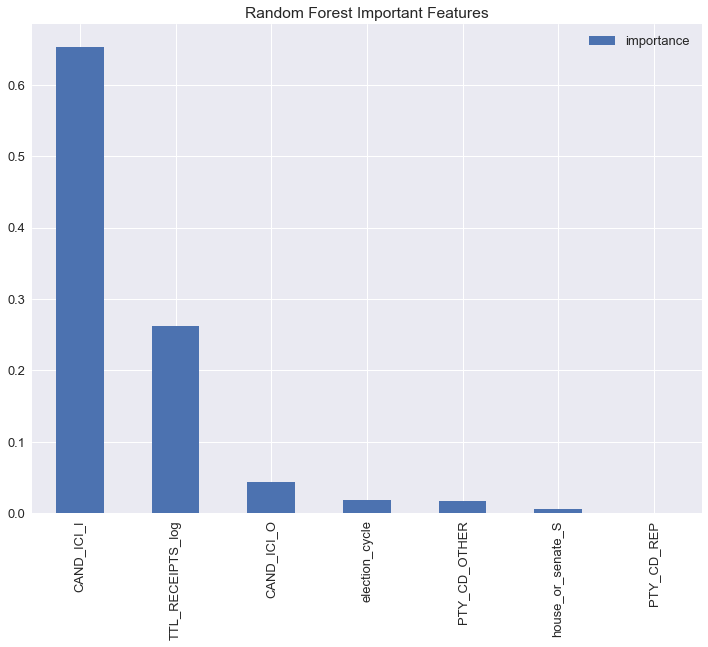

In [126]:
#important features identified by RF
#looks like most important predictors of congressional election outcomes are:
# -- incumbent candidates
# -- funds raised
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar', figsize = (12,9))
plt.title("Random Forest Important Features")
print('Random Forest Score = {:.1f}%'.format(rfc_score*100))
#print('Dummy Classifier Score = {:.1f}%'.format(incumb_wins_pct))  

#### Recall:
- L = % of losing candidates correctly predicted
- W = % of winning candidates correctly predicted

In [127]:
#recall:
# 94% of losing candidates correctly predicted
# 82% of winning candidates correctly predicted
y_pred = rfc.predict(X)
print(classification_report(y, y_pred)) 
print('Percent of congressional winning campaigns won by the incumbent 1996-2016 = {:.0f}%'.format(incumb_wins_pct))

             precision    recall  f1-score   support

          L       0.94      0.93      0.93     12866
          W       0.83      0.83      0.83      4900

avg / total       0.91      0.91      0.91     17766

Percent of congressional winning campaigns won by the incumbent 1996-2016 = 83%


In [128]:
confusion_matrix(y, y_pred)

array([[12013,   853],
       [  824,  4076]])

### 6. Explore Congressional candidates' fundraising inequality
- Large inequality gap: gilded class and middle class
- The top 1.0% of candidates have raised 23.5% of funds 1996-2018.
- The top 5.0% of candidates have raised 59.1% of funds 1996-2018.
- The top 10.0% of candidates have raised 79.1% of funds 1996-2018.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[Text(0.5,0,'Funds Raised (log)'),
 Text(0.5,1,'Distribution of Funds Raised by Candidates in an Election Cycle')]

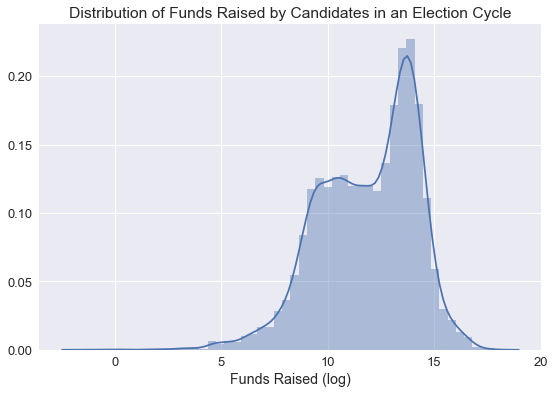

In [129]:
#Density plots of funds raised by candidates in an election cycle
#plot log values to remove skew

#there are 2 classes of fundraisers according to the bimodal shape of the distribution (2 peaks)
# --> middle class and gilded class
plt.figure(figsize = (9,6))
ax = sns.distplot(np.log(df_funds_nonzero.TTL_RECEIPTS))
ax.set(xlabel='Funds Raised (log)', 
       title='Distribution of Funds Raised by Candidates in an Election Cycle')

Text(38.1539,0.5,'Funds Raised')

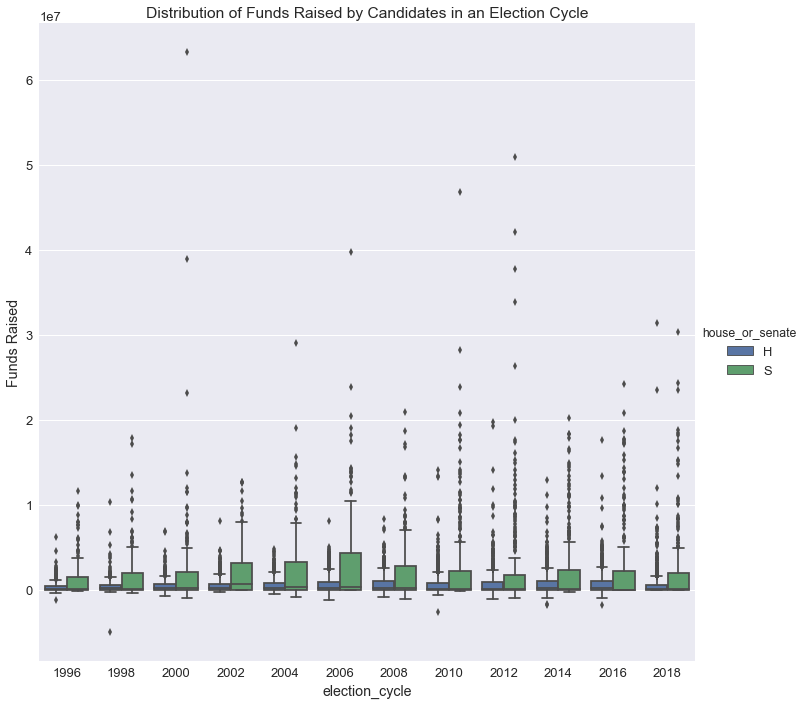

In [130]:
#box plots of funds raised by candidates, by election cycle
#data is skewed by big fund raisers
ax = sns.factorplot(
    x='election_cycle',
    y='TTL_RECEIPTS',
    data=df1,
    kind='box',
    size=10,
    hue='house_or_senate'
)

plt.title('Distribution of Funds Raised by Candidates in an Election Cycle')
plt.ylabel('Funds Raised')

The top 1.0% of candidates have raised 23.5% of funds 1996-2018.
The top 5.0% of candidates have raised 59.1% of funds 1996-2018.
The top 10.0% of candidates have raised 79.1% of funds 1996-2018.


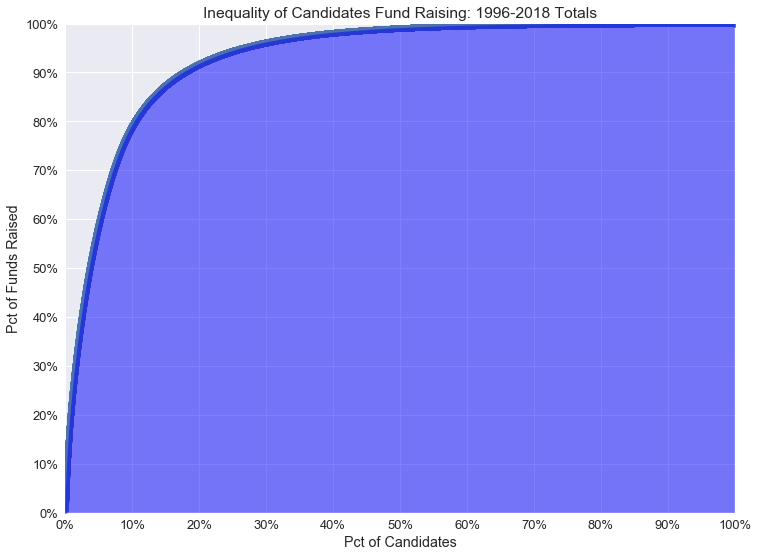

In [131]:
#Plot the inequality related to candidates fund raising
df_grp_cand = df1.groupby('CAND_ID')['TTL_RECEIPTS'].sum() 
df_grp_cand.sort_values(ascending=False, inplace=True) 
df_grp_cand = df_grp_cand.reset_index()

df_grp_cand['TTL_RECEIPTS_sum'] = df_grp_cand.TTL_RECEIPTS.cumsum() #running sum
df_grp_cand['count'] = df_grp_cand.index + 1 #running count

#running sum expressed as pct of total
df_grp_cand['TTL_RECEIPTS_sum_pct'] = df_grp_cand['TTL_RECEIPTS_sum'] / df_grp_cand.TTL_RECEIPTS.sum() * 100

#running sum expressed as pct of total
df_grp_cand['count_pct'] = df_grp_cand['count'] / len(df_grp_cand) * 100

#plot the inequality
plt.figure(figsize = (12,9))
#ax = plt.plot(df_grp_cand['count_pct'], df_grp_cand['TTL_RECEIPTS_sum_pct']) #, labels=grouped2.columns) 
ax = sns.regplot(x='count_pct', y='TTL_RECEIPTS_sum_pct', data=df_grp_cand, fit_reg=False) 

plt.xlim(0, 100)
plt.ylim(0, 100)
plt.title('Inequality of Candidates Fund Raising: 1996-2018 Totals')
plt.xlabel('Pct of Candidates')
plt.ylabel('Pct of Funds Raised')

fmt = '{x:.0f}%'
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.set_xticks(np.arange(0,101,10))
ax.set_yticks(np.arange(0,101,10))
ax.fill_between(x=df_grp_cand.count_pct, y1=df_grp_cand.TTL_RECEIPTS_sum_pct, 
                y2=0, alpha=0.5, facecolor='blue')

print('The top {:.1f}% of candidates have raised {:.1f}% of funds 1996-2018.'.format(
    df_grp_cand.iloc[136]['count_pct'], df_grp_cand.iloc[136]['TTL_RECEIPTS_sum_pct']))
print('The top {:.1f}% of candidates have raised {:.1f}% of funds 1996-2018.'.format(
    df_grp_cand.iloc[680]['count_pct'], df_grp_cand.iloc[680]['TTL_RECEIPTS_sum_pct']))
print('The top {:.1f}% of candidates have raised {:.1f}% of funds 1996-2018.'.format(
    df_grp_cand.iloc[1358]['count_pct'], df_grp_cand.iloc[1358]['TTL_RECEIPTS_sum_pct']))

### 7. Who has raised the most funds?

([<matplotlib.axis.XTick at 0x1a2f1d1518>,
 <a list of 10 Text xticklabel objects>)

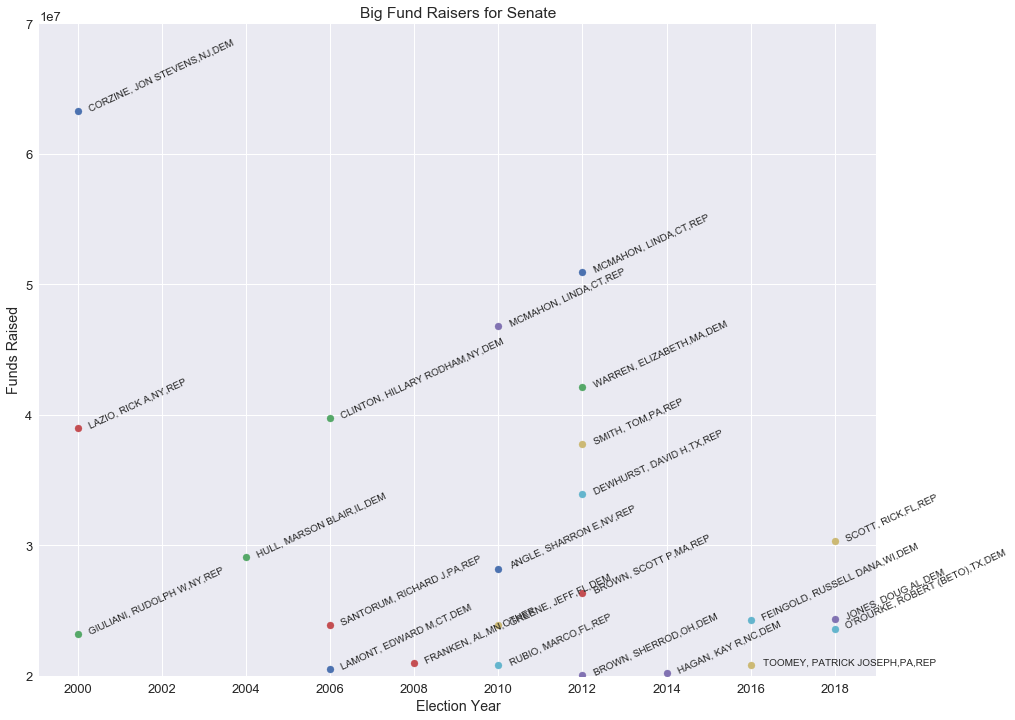

In [132]:
#explore who is raising $20m or more in a cycle, for Senate campaigns
#include 2018 cycle
df_big = df1[(df1.TTL_RECEIPTS>=20e6) & (df1.house_or_senate=='S')]

plt.figure(figsize = (15,12))
x_vals = df_big['election_cycle']
y_vals = df_big['TTL_RECEIPTS']
text_vals = df_big['CAND_NAME']+','+df_big['CAND_OFFICE_ST']+','+df_big.PTY_CD
#+df_big.CAND_OFFICE_DISTRICT.apply(str)

for i, (x, y, t) in enumerate(zip(x_vals, y_vals, text_vals)):
    plt.scatter(x, y) 
    if t[0:4]=='TOOM':
        plt.text(x+0.3, y+0.3, t, fontsize=10, rotation=0, rotation_mode='anchor')
    else:
        plt.text(x+0.3, y+0.3, t, fontsize=10, rotation=25, rotation_mode='anchor')

plt.xlabel('Election Year')
plt.ylabel('Funds Raised')
plt.title('Big Fund Raisers for Senate')
#plt.xlim(1996, 2018)
plt.ylim(20e6, 70e6)
plt.xticks(np.arange(df_big.election_cycle.min(), df_big.election_cycle.max()+1, step=2))
#plt.legend(loc=1)


([<matplotlib.axis.XTick at 0x1a2f13ea58>,
 <a list of 11 Text xticklabel objects>)

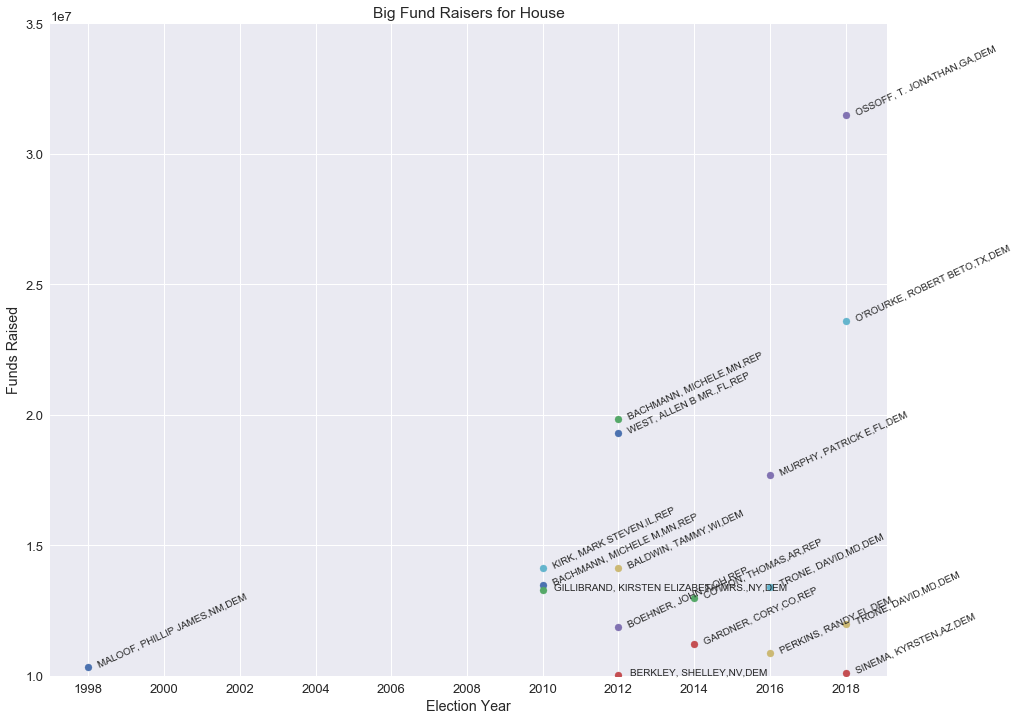

In [133]:
#explore who is raising $10m or more in a cycle, for House campaigns
#include 2018 cycle
df_big = df1[(df1.TTL_RECEIPTS>=10e6) & (df1.house_or_senate=='H')]

plt.figure(figsize = (15,12))
x_vals = df_big['election_cycle']
y_vals = df_big['TTL_RECEIPTS']
text_vals = df_big['CAND_NAME']+','+df_big['CAND_OFFICE_ST']+','+df_big.PTY_CD
#+df_big.CAND_OFFICE_DISTRICT.apply(str)

for i, (x, y, t) in enumerate(zip(x_vals, y_vals, text_vals)):
    plt.scatter(x, y) 
    if (t[0:4]=='BERK') or (t[0:4]=='GILL'):
        plt.text(x+0.3, y+0.3, t, fontsize=10, rotation=0, rotation_mode='anchor')
    else:
        plt.text(x+0.3, y+0.3, t, fontsize=10, rotation=25, rotation_mode='anchor')

plt.xlabel('Election Year')
plt.ylabel('Funds Raised')
plt.title('Big Fund Raisers for House')
#plt.xlim(2008, 2018)
plt.ylim(10e6, 35e6)
plt.xticks(np.arange(df_big.election_cycle.min(), df_big.election_cycle.max()+1, step=2))
#plt.legend(loc=1)

[Text(0,0.5,'Funds Raised'),
 Text(0.5,1,'Funds Raised by Elite Candidates 1996-2018')]

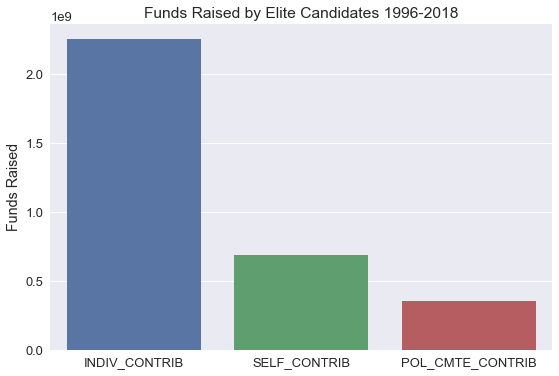

In [134]:
#who is funding the elite fundraisers? 
# --> mostly individuals and self-funding
df_big_s = df1[(df1.TTL_RECEIPTS>=10e6) & (df1.house_or_senate=='S')]
df_big_h = df1[(df1.TTL_RECEIPTS>=5e6) & (df1.house_or_senate=='H')]
df_big = pd.concat([df_big_s, df_big_h], axis=0)

#consolidate col's for plot
df_big['INDIV_CONTRIB'] = df_big.TTL_INDIV_CONTRIB
df_big['POL_CMTE_CONTRIB'] = df_big.OTHER_POL_CMTE_CONTRIB + df_big.POL_PTY_CONTRIB
df_big['SELF_CONTRIB'] = df_big.CAND_CONTRIB + df_big.CAND_LOANS + df_big.OTHER_LOANS

df_big_sum = df_big[['INDIV_CONTRIB','POL_CMTE_CONTRIB','SELF_CONTRIB']].sum()

df_big_sum.sort_values(ascending=False, inplace=True)


plt.figure(figsize = (9,6))
ax = sns.barplot(x= df_big_sum.index.values, y = df_big_sum)
sns.set(font_scale=1.3)
ax.set(ylabel='Funds Raised',
       title='Funds Raised by Elite Candidates 1996-2018')

### Import committee master data, identify campaign expenditures by industry
- not used, too cumbersome to group by industry (~2700 connected organizations)

In [135]:
#import cammittee master data for all election cycles
#import glob
#the_files = list(glob.glob('../ga_projects/data/committee-master/cm*.txt'))

#col_list = ['CMTE_ID',
 #        'CMTE_NM', 'TRES_NM', 'CMTE_ST1', 'CMTE_ST2', 'CMTE_CITY',
  #       'CMTE_ST', 'CMTE_ZIP', 'CMTE_DSGN', 'CMTE_TP', 'CMTE_PTY_AFFILIATION',
   #      'CMTE_FILING_FREQ', 'ORG_TP', 'CONNECTED_ORG_NM', 'CAND_ID']

In [136]:
#committee types:
#I = Independent expenditor (other than PACs)
#O =Independent expenditure-only (Super PACs)
#U = Single-candidate independent expenditure
#V, W = PAC's that also have some indep expenditures
#df_cm.groupby('CMTE_TP').size()

In [137]:
#there are 2700 connected organization of selected committees, too many to group into industries
#len(df_cm.CONNECTED_ORG_NM.unique())

### Import PAC Summary data
- overall receipts and disbursements for each PAC and party committee registered with the FEC
- one record for each PAC
- along with a breakdown of overall receipts by source, independent expenditures made and other information

In [138]:
col_list = ['CMTE_ID',
'CMTE_NM',
'CMTE_TP',
'CMTE_DSGN',
'CMTE_FILING_FREQ',
'TTL_RECEIPTS',
'TRANS_FROM_AFF',
'INDV_CONTRIB',
'OTHER_POL_CMTE_CONTRIB',
'CAND_CONTRIB',
'CAND_LOANS',
'TTL_LOANS_RECEIVED',
'TTL_DISB',
'TRANF_TO_AFF',
'INDV_REFUNDS',
'OTHER_POL_CMTE_REFUNDS',
'CAND_LOAN_REPAY',
'LOAN_REPAY',
'COH_BOP',
'COH_COP',
'DEBTS_OWED_BY',
'NONFED_TRANS_RECEIVED',
'CONTRIB_TO_OTHER_CMTE',
'IND_EXP',
'PTY_COORD_EXP',
'NONFED_SHARE_EXP',
'CVG_END_DT']

In [139]:
#import PAC financial data for all election cycles
import glob
the_files = list(glob.glob('../ga_projects/data/pac-data/web*.txt'))

df_list = []
for a_file in the_files:
    data = pd.read_csv(a_file, sep='|', header=None, names = col_list)
    #add column indicating the election cycle (ex: 2016 = 2014-16 cycle)
    yr = a_file[len(a_file)-6: len(a_file)-4]
    if yr[0:1]=='9':
        yr = 1900 + int(yr)
    else:
        yr = 2000 + int(yr)
    data['election_cycle'] = yr
    df_list.append(data)

df_pac = pd.concat(df_list, axis=0)
    
df_pac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92128 entries, 0 to 6559
Data columns (total 28 columns):
CMTE_ID                   92128 non-null object
CMTE_NM                   92127 non-null object
CMTE_TP                   92128 non-null object
CMTE_DSGN                 92102 non-null object
CMTE_FILING_FREQ          92128 non-null object
TTL_RECEIPTS              73676 non-null float64
TRANS_FROM_AFF            73676 non-null float64
INDV_CONTRIB              73676 non-null float64
OTHER_POL_CMTE_CONTRIB    73676 non-null float64
CAND_CONTRIB              73676 non-null float64
CAND_LOANS                73676 non-null float64
TTL_LOANS_RECEIVED        73676 non-null float64
TTL_DISB                  73676 non-null float64
TRANF_TO_AFF              73676 non-null float64
INDV_REFUNDS              73676 non-null float64
OTHER_POL_CMTE_REFUNDS    73676 non-null float64
CAND_LOAN_REPAY           73676 non-null float64
LOAN_REPAY                73676 non-null float64
COH_BOP        

### 8. Independent Expenditures and Outside Money
- Independent Expenditures = political expenditures made by groups or individuals independently of, and not coordinated with, candidates' election committees
- Groups in this category range from conventional party committees to super PACs and 501(c) "dark money" organizations
- Dark money = independent expenditures from organizations whose donors or funding sources are undisclosed, principally politically active nonprofit 501(c)(4)s and 501(c)(6)s 
- There is no way to comprehensively identify all such organizations' spending.
- Amounts are limited to spending reported to the FEC and likely do not include all "dark money" spending, or independent spending by corporations and individuals.
- Lobbying-related expenditures by corporations and interest groups also completely excluded.

In [140]:
#Independent expenditures by election cycle
# --> spending spiked in 2012 and 2016 presidential election years

pd.options.display.float_format = '${:,.0f}'.format
df_pac.groupby('election_cycle')['IND_EXP'].sum()

election_cycle
1996      $22,529,806
1998      $12,108,617
2000      $26,847,624
2002      $20,778,407
2004     $325,153,164
2006     $261,252,889
2008     $404,164,029
2010     $307,654,587
2012     $954,498,411
2014     $619,933,776
2016   $1,436,473,712
2018     $214,331,472
Name: IND_EXP, dtype: float64

Index(['CAMPAIGN_CONTRIB', 'INDEP_EXP'], dtype='object')


(1996, 2018)

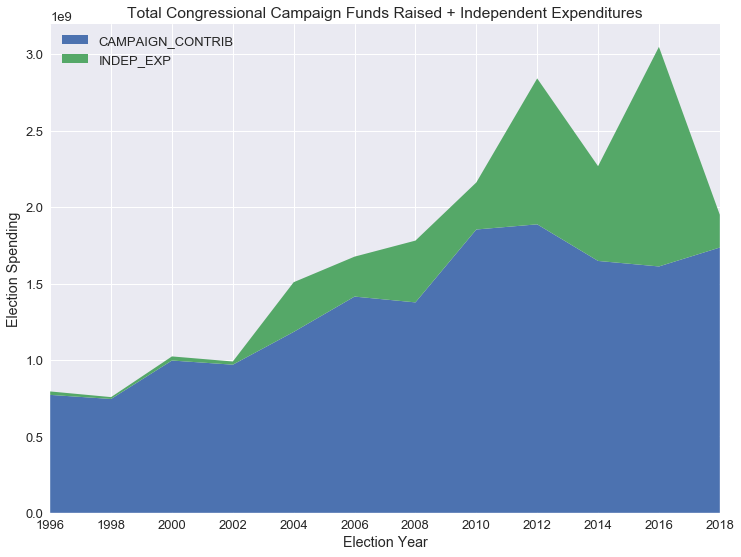

In [141]:
#Growth in total [congressional campaign contributions + independent expenditures] across election cycles

grouped_campaigns = df1.groupby('election_cycle')['TTL_RECEIPTS'].sum().reset_index()
grouped_indep_exp = df_pac.groupby('election_cycle')['IND_EXP'].sum().reset_index()

#columns for stack chart
grouped2 = pd.DataFrame()
grouped2['CAMPAIGN_CONTRIB'] = grouped_campaigns['TTL_RECEIPTS']
grouped2['INDEP_EXP'] = grouped_indep_exp['IND_EXP']
print(grouped2.columns)

plt.figure(figsize = (12,9))
x_vals = grouped_campaigns['election_cycle']
y_vals = grouped2.T 

ax = plt.stackplot(x_vals, y_vals, labels=grouped2.columns) 
plt.legend(loc='upper left')
plt.title('Total Congressional Campaign Funds Raised + Independent Expenditures')
plt.xlabel('Election Year')
plt.ylabel('Election Spending')
plt.xticks(np.arange(x_vals.iloc[0], x_vals.iloc[-1]+1, 2))
plt.xlim(x_vals.iloc[0], x_vals.iloc[-1])
#ax = sns.barplot(x='house_or_senate', y='TTL_RECEIPTS',data=grouped)
#sns.set(font_scale=1.3)

#TODO: format y axis in $ billions
#fmt = '${x:,.0f}'

#plt.Axes.get_yaxis().ticker.FormatStrFormatter('${x:,.0f}')
#ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('${x:,.0f}'))

#### Top 50 biggest independent expenditors, 1996 - 2018

[Text(0,0.5,''),
 Text(0.5,0,'Expenditures'),
 Text(0.5,1,'Top 50 Independent Expenditors in Elections, 1996-2018')]

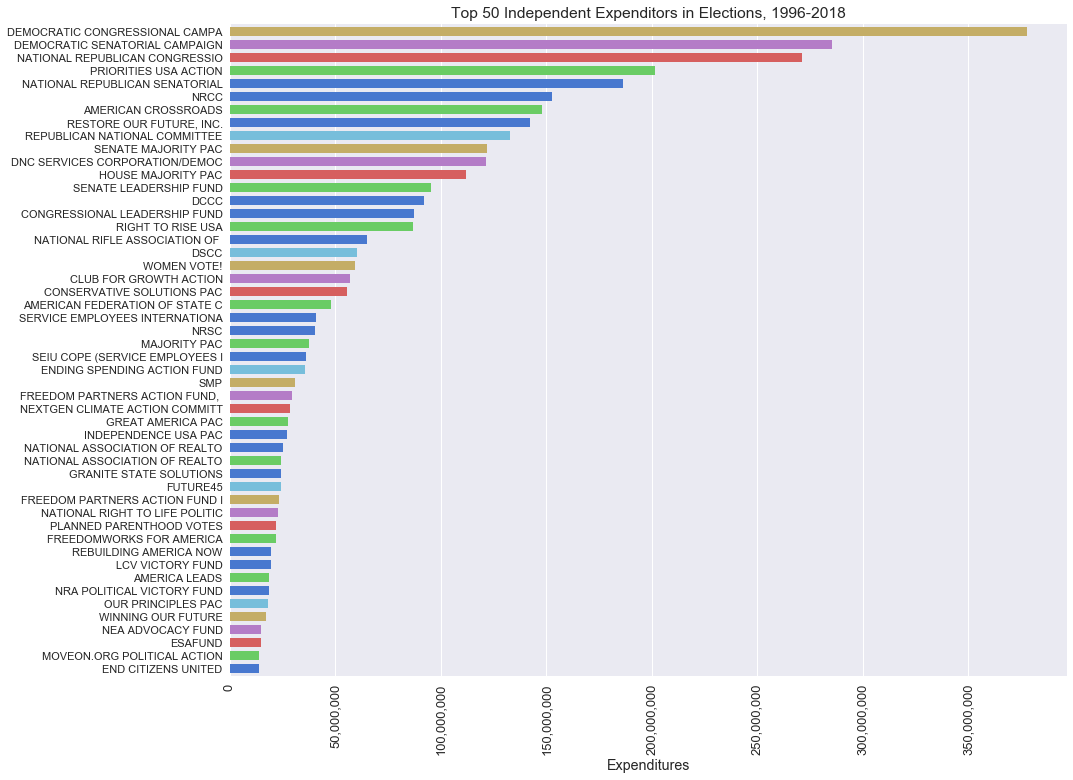

In [142]:
#top 50 biggest independent expenditors, 1996 - 2018
#--> including party committees
grouped_indep_top50 = df_pac.groupby('CMTE_NM')['IND_EXP'].sum().nlargest(50).reset_index()
grouped_indep_top50['short_name'] = grouped_indep_top50['CMTE_NM'].str[0:30]
grouped_indep_top50.sort_values(by='IND_EXP', ascending=True, inplace=True)
#print(grouped_indep_top50)

ax = grouped_indep_top50.plot('short_name', 'IND_EXP', kind="barh", width=0.7,
                  figsize = (15,12), color=sns.color_palette("muted", 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax.yaxis.grid(False)
#plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90)
#plt.yticks(labelsize = 3)
ax.tick_params(axis = 'y', labelsize = 11)
ax.legend_.remove()
fmt = '{x:,.0f}'
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.set(xlabel='Expenditures', ylabel='',
       title='Top 50 Independent Expenditors in Elections, 1996-2018')

[Text(0,0.5,''),
 Text(0.5,0,'Expenditures'),
 Text(0.5,1,'Top 50 Independent Expenditors in Elections 2012-2018, excluding Party Committees')]

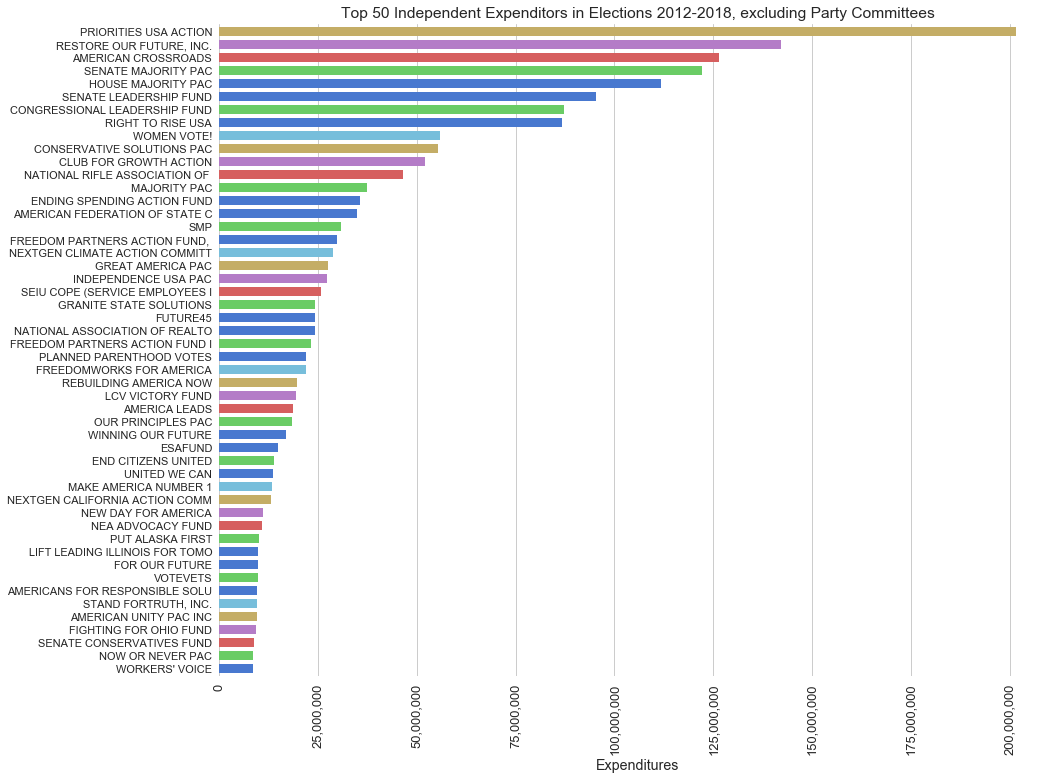

In [143]:
#top 50 biggest independent expenditors, 2012 - 2018
#--> excluding party committees (types 'X' & 'Y')

grouped_indep_top50_ex = df_pac[(df_pac.CMTE_TP!='X') & (df_pac.CMTE_TP!='Y') & (df_pac.election_cycle>=2012)
                               ].groupby('CMTE_NM')['IND_EXP'].sum().nlargest(50).reset_index()
grouped_indep_top50_ex['short_name'] = grouped_indep_top50_ex['CMTE_NM'].str[0:30]
grouped_indep_top50_ex.sort_values(by='IND_EXP', ascending=True, inplace=True)

#grouped_indep_top50_ex.head(10)
ax = grouped_indep_top50_ex.plot('short_name', 'IND_EXP', kind="barh", width=0.7,
                  figsize = (15,12), color=sns.color_palette("muted", 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax.yaxis.grid(False)
#plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90)
#plt.yticks(labelsize = 3)
ax.tick_params(axis = 'y', labelsize = 11)
ax.legend_.remove()
fmt = '{x:,.0f}'
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.set(xlabel='Expenditures', ylabel='',
       title='Top 50 Independent Expenditors in Elections 2012-2018, excluding Party Committees')

### 9. Top 50 biggest individual donors to elections
- determine largest individuals donors to political campaigns and PACs, July 2017 - July 2018
- (narrow date range to limit file size)

In [144]:
col_list = ['CMTE_ID',
            'AMNDT_IND',
            'RPT_TP',
            'TRANSACTION_PGI',
            'IMAGE_NUM',
            'TRANSACTION_TP',
            'ENTITY_TP',
            'NAME',
            'CITY',
            'STATE',
            'ZIP_CODE',
            'EMPLOYER',
            'OCCUPATION',
            'TRANSACTION_DT',
            'TRANSACTION_AMT',
            'OTHER_ID',
            'TRAN_ID',
            'FILE_NUM',
            'MEMO_CD',
            'MEMO_TEXT',
            'SUB_ID']

In [145]:
#import campaign-related contributions by individuals, July 2017 - July 2018
import glob
the_files = list(glob.glob('../ga_projects/data/indiv_contributions/itcont*.txt'))

df_list = []
for a_file in the_files:
    data = pd.read_csv(a_file, sep='|', header=None, names = col_list)
    df_list.append(data)

df_indiv = pd.concat(df_list, axis=0)
    
df_indiv.info()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7912067 entries, 0 to 1981388
Data columns (total 21 columns):
CMTE_ID            object
AMNDT_IND          object
RPT_TP             object
TRANSACTION_PGI    object
IMAGE_NUM          int64
TRANSACTION_TP     object
ENTITY_TP          object
NAME               object
CITY               object
STATE              object
ZIP_CODE           object
EMPLOYER           object
OCCUPATION         object
TRANSACTION_DT     int64
TRANSACTION_AMT    int64
OTHER_ID           object
TRAN_ID            object
FILE_NUM           int64
MEMO_CD            object
MEMO_TEXT          object
SUB_ID             int64
dtypes: int64(5), object(16)
memory usage: 1.3+ GB


#### Donations to the American Action Network are not tax deductible due to its 501(c)(4) status, and the organization is not required to disclose the source of donations. 

[Text(0,0.5,''),
 Text(0.5,0,'Contributions'),
 Text(0.5,1,'Largest Individual Donors July 2017-July 2018')]

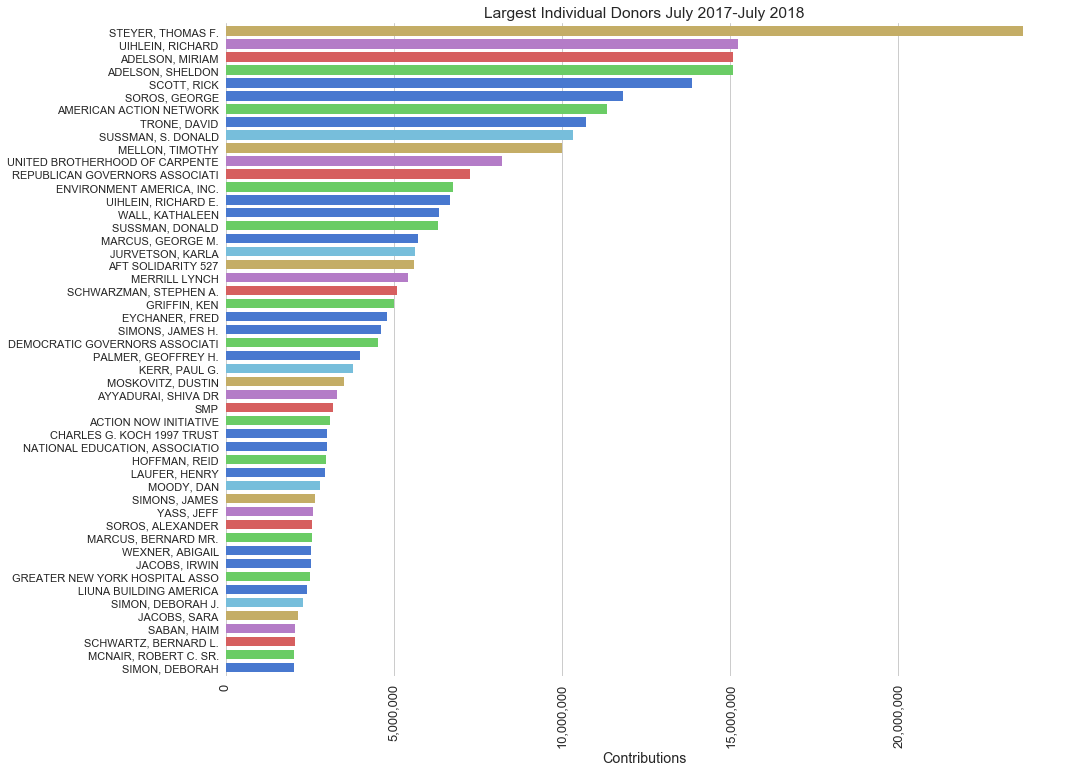

In [146]:
#get 50 largest individual donors, July 2017 - July 2018
#some of these are 501(c) "dark money" groups
df_indiv_top50 = df_indiv.groupby('NAME')['TRANSACTION_AMT'].sum().nlargest(50).reset_index()
df_indiv_top50['short_name'] = df_indiv_top50['NAME'].str[0:30]
df_indiv_top50.sort_values(by='TRANSACTION_AMT', ascending=True, inplace=True)

ax = df_indiv_top50.plot('short_name', 'TRANSACTION_AMT', kind="barh", width=0.7,
                  figsize = (15,12), color=sns.color_palette("muted", 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax.yaxis.grid(False)
#plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90)
#plt.yticks(labelsize = 3)
ax.tick_params(axis = 'y', labelsize = 11)
ax.legend_.remove()
fmt = '{x:,.0f}'
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.set(xlabel='Contributions', ylabel='',
       title='Largest Individual Donors July 2017-July 2018')

### 10. Political Committee Expenditures
- spending by category of political and campaign committees

In [147]:
col_list = ['CMTE_ID',
            'AMNDT_IND',
            'RPT_YR',
            'RPT_TP',
            'IMAGE_NUM',
            'LINE_NUM',
            'FORM_TP_CD',
            'SCHED_TP_CD',
            'NAME',
            'CITY',
            'STATE',
            'ZIP_CODE',
            'TRANSACTION_DT',
            'TRANSACTION_AMT',
            'TRANSACTION_PGI',
            'PURPOSE',
            'CATEGORY',
            'CATEGORY_DESC',
            'MEMO_CD',
            'MEMO_TEXT',
            'ENTITY_TP',
            'SUB_ID',
            'FILE_NUM',
            'TRAN_ID',
            'BACK_REF_TRAN_ID']

In [148]:
#import policitical committe expenditures, for the 2016 election cycle
import glob
the_files = list(glob.glob('../ga_projects/data/committee-expenditures/opp*.txt'))

df_list = []
for a_file in the_files:
    data = pd.read_csv(a_file, sep='|', header=None, names = col_list,
                       encoding = 'latin1', engine='python', index_col=False)
    df_list.append(data)

df_pac_exp = pd.concat(df_list, axis=0)
    
df_pac_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754702 entries, 0 to 1754701
Data columns (total 25 columns):
CMTE_ID             object
AMNDT_IND           object
RPT_YR              int64
RPT_TP              object
IMAGE_NUM           int64
LINE_NUM            object
FORM_TP_CD          object
SCHED_TP_CD         object
NAME                object
CITY                object
STATE               object
ZIP_CODE            object
TRANSACTION_DT      object
TRANSACTION_AMT     float64
TRANSACTION_PGI     object
PURPOSE             object
CATEGORY            object
CATEGORY_DESC       object
MEMO_CD             object
MEMO_TEXT           object
ENTITY_TP           object
SUB_ID              int64
FILE_NUM            int64
TRAN_ID             object
BACK_REF_TRAN_ID    object
dtypes: float64(1), int64(4), object(20)
memory usage: 334.7+ MB


In [149]:
df_pac_exp.groupby('ENTITY_TP')['TRANSACTION_AMT'].sum()

ENTITY_TP
CAN       $8,592,256
CCM      $10,641,490
COM      $10,381,749
IND     $559,591,536
ORG   $3,818,918,224
PAC      $12,906,497
PTY      $30,315,095
Name: TRANSACTION_AMT, dtype: float64

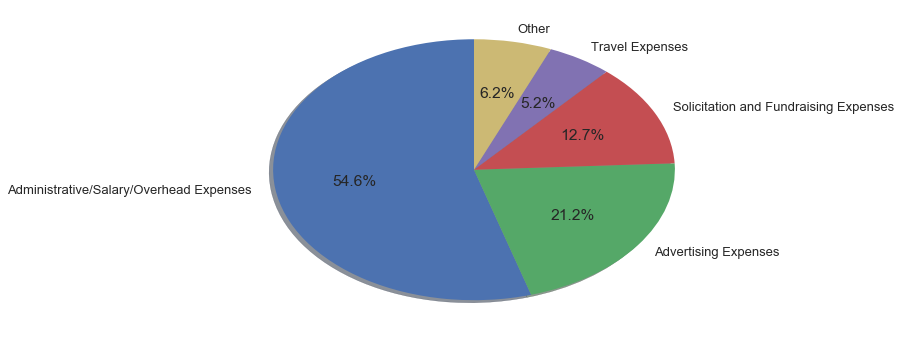

In [150]:
#pie chart of political committee expenditures, 2016 election cycle
# --> looks like only campaign committees? (excludes PACs?) --> NOT CLEAR
df_pac_exp_grp = df_pac_exp.groupby('CATEGORY_DESC')['TRANSACTION_AMT'].sum().nlargest(50).reset_index()

#condolidate the smaller categories
df_pac_exp_grp.loc[12, 'TRANSACTION_AMT'] = df_pac_exp_grp['TRANSACTION_AMT'].iloc[4:].sum()
df_pac_exp_grp.loc[12, 'CATEGORY_DESC'] = 'Other'
df_pac_exp_grp.drop(df_pac_exp_grp.index[4:12], inplace=True)
#df_pac_exp_grp.head(50)

plt.figure(figsize = (9,6))
ax = plt.pie(df_pac_exp_grp['TRANSACTION_AMT'], labels=df_pac_exp_grp['CATEGORY_DESC'],
        autopct='%1.1f%%', shadow=True, startangle=90)


### 11. Interactive Map of the Fundraising Statistics by State
- created with folium

In [152]:
import os
import json
import folium
import vincent
import branca

[Text(0,0.5,'State'),
 Text(0.5,0,'Mean Funds Raised by Candidate'),
 Text(0.5,1,'Average Funds Raised by Candidates in an Election Cycle')]

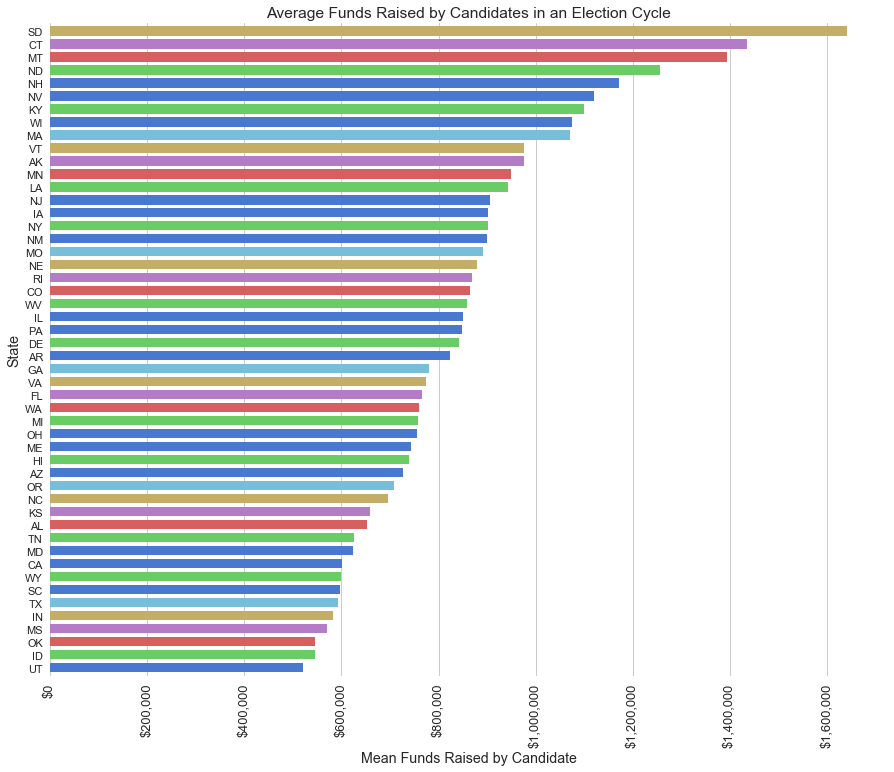

In [153]:
#avg funds raised by candidates, split by state
#South Dakota, North Dakota and Montana campaigns are big fundraisers: needs exploring

#plt.figure(figsize = (20,15))
grouped = df1.groupby('CAND_OFFICE_ST')['TTL_RECEIPTS'].mean().reset_index()
grouped.sort_values(by='TTL_RECEIPTS',ascending=True, inplace=True)
#ax = sns.barplot(x='CAND_OFFICE_ST', y='TTL_RECEIPTS',data=grouped)
ax = grouped.plot('CAND_OFFICE_ST', 'TTL_RECEIPTS', kind="barh", width=0.7,
                  figsize = (15,12), color=sns.color_palette("muted", 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#sns.set(font_scale=1.3)
sns.set_style("whitegrid")
ax.yaxis.grid(False)
#plt.style.use('seaborn-whitegrid')
plt.xticks(rotation=90)
#plt.yticks(labelsize = 3)
ax.tick_params(axis = 'y', labelsize = 11)
ax.legend_.remove()
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter(fmt)) 
ax.set(xlabel='Mean Funds Raised by Candidate', ylabel='State',
       title='Average Funds Raised by Candidates in an Election Cycle')

In [154]:
#Create dataframes needed to render map
#parameters of this function:
# --> df1 = the main dataframe containing campaign finance data
# --> agg_func = the agg function for calculating state-wide statistics as a string ('mean' or 'sum')

def create_df(df1, agg_func):
    df_list =[]
    #average funds raised by campaigns by state, all years combined:
    df_states = df1.groupby('CAND_OFFICE_ST')['TTL_RECEIPTS'].agg(agg_func).reset_index()
    df_states.columns = ['State', 'Avg_Funds_Raised']
    df_list.append(df_states)
    #df_states.sort_values(by='TTL_RECEIPTS',ascending=True, inplace=True)
    #years = df1.election_cycle.unique()
    #years = np.sort(years)

    #also calculate averages by election year by state
    df1_sorted = df1[['CAND_OFFICE_ST','election_cycle','TTL_RECEIPTS']].sort_values(
                    by='election_cycle', ascending=True)
    df_states_yrs = df1_sorted.groupby(['CAND_OFFICE_ST', 'election_cycle'])['TTL_RECEIPTS'].agg(agg_func).reset_index()
    df_states_yrs.set_index('CAND_OFFICE_ST', inplace=True)
    #df_states_yrs.loc['NY']['TTL_RECEIPTS'] #--> to get the series across yrs for single state
    df_list.append(df_states_yrs)

    #dataframe of top fundraisers by state: total amount raised across all years (sum, not mean)
    df_cand_grp = df1.groupby(['CAND_ID','CAND_OFFICE_ST'])[['CAND_NAME','TTL_RECEIPTS']]
    #get 1st candidate name in groups because they can be spelled differently for same candidate
    aggregations = {'CAND_NAME':lambda x:x.loc[x.first_valid_index()], 'TTL_RECEIPTS':'sum'}
    df_cand = df_cand_grp.agg(aggregations).reset_index()

    #get 5 biggest fundraisers in each state:
    df_cand = df_cand.groupby('CAND_OFFICE_ST')[['CAND_NAME','TTL_RECEIPTS']].apply(
        lambda x: x.nlargest(5, columns='TTL_RECEIPTS'))
    #df_cand.loc['NY'][['CAND_NAME','TTL_RECEIPTS']]#--> to get the 5 biggest raisers in NY
    #print(df_cand.loc['NY'].to_string(index=False))
    
    #remove quote characters from candidate names: causes issue in folium when displaying those names
    df_cand['CAND_NAME'] = df_cand['CAND_NAME'].str.replace('\'', '')
    df_list.append(df_cand)
    
    return df_list

In [155]:
#Two style functions we'll need to render map colors:

#the default style of each state geojson added to map
# --> make them opaque to not hide the choropleth layer 
# --> each feature in the geojson is passed to this function
# --> if there is data in the geojson we can access it this way (by reading the feature data)(not used here)
def style_func(feature):
    return {
        'fillOpacity': 0.0,
        'fillColor': None,
        'weight': 0.0,
        'color': 'black'
    } #weight & color refer to the boundary line

#determines the style when hovering over a state geojson:
def highlight_func(feature):
    return {
        'fillOpacity': 0.0,
        'fillColor': None,
        'weight': 3.0,
        'color': 'black'
    }

In [156]:
#Function to draw the map
#parameters of this function:
# --> df1 = the main dataframe containing campaign finance data
# --> agg_func = the agg function for calculating state-wide statistics as a string ('mean' or 'sum')

def create_map(df1, agg_func):
    df_list = create_df(df1, agg_func)
    
    df_states = df_list[0]
    df_states_yrs = df_list[1]
    df_cand = df_list[2]
    
    #load shape file in geojson format of US state boundaries
    us_states = os.path.join('data/folium/', 'us-states.json')
    
    #create base map with starting coordinates
    the_tiles = 'Cartodb Positron'
    # tiles: OpenStreetMap, Stamen Terrain, Stamen Toner, Mapbox Bright, and Mapbox Control Room,
    #        stamenwatercolor, Cartodb Positron,

    m = folium.Map(location=[45.5236, -122.6750],
                    zoom_start=5, tiles=the_tiles)  

    # Add choropleth layer to map, bound to data:
    # --> key_on: specifies which feature to use in the geoJSON file, always starts with 'feature'
    # --> columns: 2 col's to use in the dataframe
    #---------- 1st col lines up with the key_on, it must match the key_on codes (= state abbreviations)
    #---------- 2nd col are values used for choropleth shading
    #fill color: palette used for shading; 'YlGn' = yellow ranging to green
    #threshold scale: labels the legend, eg [100,200,300,400]); if omitted it's equally divided based on the data

    #add the choropleth layer:
    # --> this shades the geojson features (states) according to the bound data
    legn_name = ''
    if (agg_func=='mean'):
        legn_name='Average Funds Raised by Congressional Campaigns 1996-2018'
    else:
        legn_name='Total Congressional Campaign Funds Raised 1996-2018'
    m.choropleth(
        geo_data=us_states,
        data=df_states,
        columns=['State', 'Avg_Funds_Raised'],
        key_on='feature.id',
        fill_color='YlGn',
        highlight=True,
        name=agg_func,
        legend_name=legn_name
    )

    '''
    m.choropleth(
        fill_opacity=0.7,
        line_opacity=0.2,
    )
    '''

    # ----- Add additional layers to map for each state -----

    #Loop through the states, add each as additional layer to map
    # --> necessary to add pop-ups to each geojson feature (states) 
    # --> works around limitation in folium choropleth layer where pop-ups appear to be unsupported
    all_states = json.load(open(us_states))
    #state_geojson = folium.GeoJson(open(us_states))
    
    #for feat in all_states['features']:
    for i in np.arange(0,50):
        the_state = all_states['features'][i]['geometry'] #get a state's polygon
        state_name = all_states['features'][i]['id']
        #print(state_name)
        state_geojson = folium.GeoJson(the_state, name=state_name, overlay=True, control=False,
                                   style_function=style_func, highlight_function=highlight_func)

        #--- add popup for the state: add elements to an iFrame, and put iFrame in the popup ---
        
        #write table of top raising candidates to the iframe, as html
        html_table=df_cand.loc[state_name].to_html(index=False)
        #add a title to the html containing total state funds raised
        soup = BeautifulSoup(html_table, "lxml")
        htag = soup.new_tag('h3')
        htag.string = state_name+': '+legn_name+' = '
        htag.append(soup.new_tag('br')) #line break
        row_nr = df_states.loc[df_states['State']==state_name].index[0] #row number for state
        amt = '${:,.0f}'.format(df_states['Avg_Funds_Raised'].iloc[row_nr])
        htag.append(amt)
        #df_states['State', 'Avg_Funds_Raised']
        soup.insert(0, htag)
        html_table = soup.prettify() #--> to get the html from the Soup object
        iframe = branca.element.IFrame(html=html_table, height=450, width=650)
        
        #also put a line chart in the iframe showing funds raised by year
        df_state = df_states_yrs.loc[state_name].reset_index() #funds raised by year for given state
        df_state = df_state.set_index('election_cycle')
        
        line = vincent.Area(df_state['TTL_RECEIPTS'], height=200, width=400) 
        line.axis_titles(x='Election Year', y='Funds Raised')
        f = branca.element.Figure(height=200, width=400)
        folium.Vega(line, height=200, width=400).add_to(f)
        iframe.add_child(f)
        #f.add_to(iframe)
        
        #put the iframe in the popup
        state_popup = folium.Popup(iframe, max_width=650) #put iframe in popup
        
        state_geojson.add_child(state_popup)
        #state_tip = folium.Tooltip('Click me, I am '+state_name+'!')
        #state_geojson.add_child(state_tip)
        state_geojson.add_to(m)


    #todo: state popups (visualizations or data):
    # ..include either a Vega plot in the popup, or a dataframe table as above
    

    #this call adds a layers dropdown menu to map that is user controlled, to toggle layers on/off
    #folium.LayerControl().add_to(m)

    #how to enable lat/long popups (click to pop):
    #m.add_child(folium.LatLngPopup())
    return m

In [157]:
#draw map displaying average campaign funds by state
m1 = create_map(df1, 'mean')
m1
#m1.save('data/map1.html')

In [158]:
#draw map displaying total campaign funds raised by state
m2 = create_map(df1, 'sum')
m2
#m2.save('data/map2.html')

#### TODO:
- Scrape lobbying expenditures, add to data
- lobbying activity (bills and agencies lobbied, LD203 contributions)
- Spending by industry / interest group
- total spending = campaign contributions + super pac/indep exp + lobbying + dark money 
- --> dark money is partly included (portion disclosed to FEC) but lobbying still TODO: scrape from open secrets
- put runnable script in the pop ups, like an app
- what return do business groups get on their “investment”
- do their lobbied bills pass? 